## Imports and Setup
Imports essential libraries for data analysis, visualization, machine learning, and custom data cleaning functions. Sets up the path to import project-specific modules.

In [ ]:
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.insert(1, '../src')
from fraud_data_cleanup import clean_fraud_data, sanity_report

## Load Data
Loads the fraud and credit card datasets from CSV files. Handles missing file errors gracefully by printing an error message.

In [2]:
try:
    fraud_df = pd.read_csv('../data/Fraud_Data.csv')
    credit_df = pd.read_csv('../data/creditcard.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Please check the file paths.")

In [3]:
# Check for missing values
print(fraud_df.isnull().sum())
print(credit_df.isnull().sum())

fraud_df.fillna({'browser': 'Unknown'}, inplace=True)

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:
fraud_df = clean_fraud_data(fraud_df)
sanity_report(fraud_df)

user_id: int64, Nulls: 0, Unique: 151112
signup_time: object, Nulls: 0, Unique: 151112
purchase_time: object, Nulls: 0, Unique: 150679
purchase_value: int64, Nulls: 0, Unique: 122
device_id: object, Nulls: 0, Unique: 137956
source: object, Nulls: 0, Unique: 3
browser: object, Nulls: 0, Unique: 5
sex: object, Nulls: 0, Unique: 2
age: int64, Nulls: 0, Unique: 58
ip_address: float64, Nulls: 0, Unique: 143512
class: int64, Nulls: 0, Unique: 2
Invalid timestamps: 0
Mixed type columns: []
Shape: (151112, 14)
Any nulls? False
Dtypes: int64             7
object            4
datetime64[ns]    2
float64           1
Name: count, dtype: int64


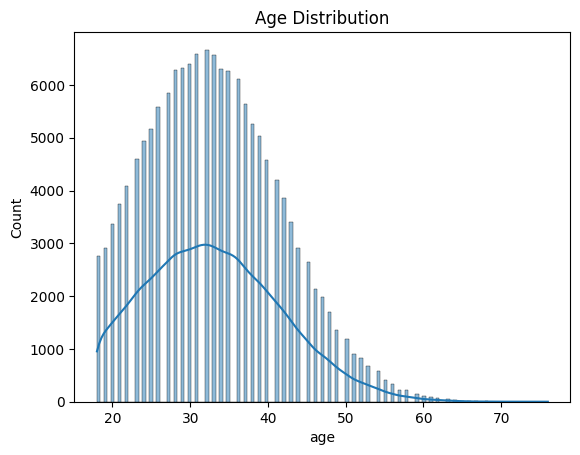

In [5]:
sns.histplot(fraud_df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

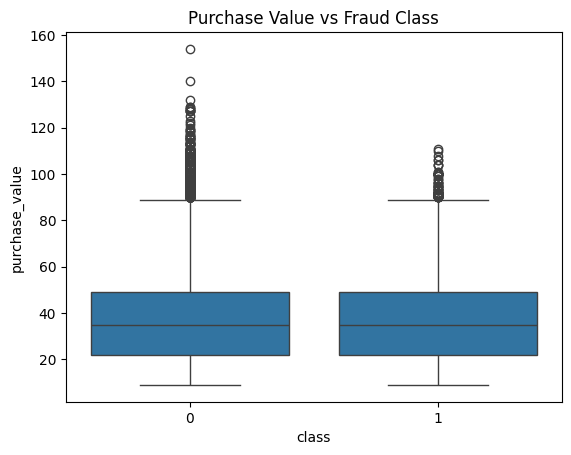

In [6]:
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title('Purchase Value vs Fraud Class')
plt.show()

In [7]:
try:
    ip_df = pd.read_csv('../data/IpAddress_to_Country.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Please check the file paths.")

In [8]:
def find_country(ip):
    match = ip_df[(ip_df['lower_bound_ip_address'] <= ip) & (ip_df['upper_bound_ip_address'] >= ip)]
    return match['country'].values[0] if not match.empty else 'Unknown'

In [9]:
fraud_df['country'] = fraud_df['ip_address'].apply(find_country)

In [10]:
fraud_df.sample(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,is_high_freq_device,ip_freq,is_outlier_purchase,country
17273,65226,2015-02-06 04:45:07,2015-02-22 21:47:47,29,VKAQXSNPUIEFP,Seo,Ie,M,29,1.538154e+09,0,0,1,0,France
70946,226714,2015-05-10 21:33:44,2015-05-21 15:09:24,26,USRVKMBDHUWLF,Ads,Chrome,M,20,3.471046e+09,0,0,1,0,United States
148990,338678,2015-03-28 11:41:19,2015-06-24 08:02:18,47,GYXCSYNJLRWTB,Ads,Firefox,F,60,1.838156e+09,0,0,1,0,United Kingdom
2785,293979,2015-03-03 23:00:31,2015-06-09 04:12:48,29,BFXIDWNSKJHDC,Seo,Ie,F,33,1.644989e+09,0,0,1,0,United States
54029,116070,2015-08-05 17:04:59,2015-10-21 14:44:51,48,IKERDDJOGOMEA,Ads,Chrome,F,43,2.390240e+09,0,0,1,0,Canada


In [11]:
# Time-Based Features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['month'] = fraud_df['purchase_time'].dt.month
fraud_df['year'] = fraud_df['purchase_time'].dt.year

fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

In [12]:
# Number of transactions per device
txn_count = fraud_df.groupby('device_id').size().rename('txn_count')
fraud_df = fraud_df.join(txn_count, on='device_id')


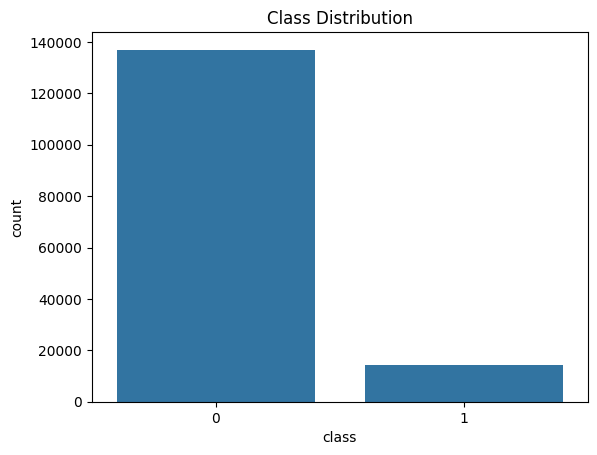

In [13]:
# Handle calss imbalance
sns.countplot(x='class', data=fraud_df)
plt.title('Class Distribution')
plt.show()

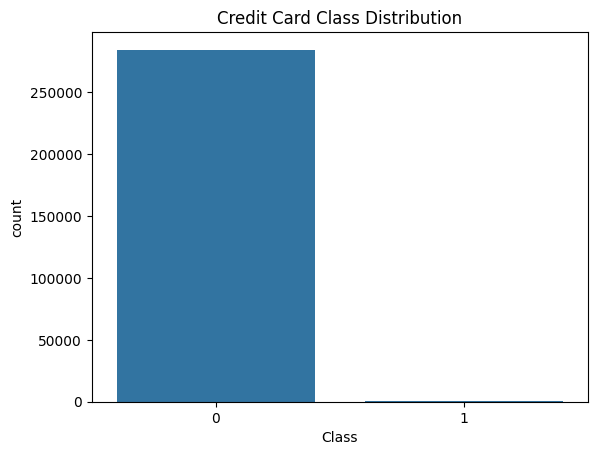

In [14]:
sns.countplot(x='Class', data=credit_df)
plt.title('Credit Card Class Distribution')
plt.show()

In [ ]:
X = fraud_df.drop(columns=['class'])
y = fraud_df['class']

# One-hot encode before sampling
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
# Only scale 'Amount'
X_train_resampled['Amount'] = scaler.fit_transform(X_train_resampled[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])


In [ ]:
X = credit_df.drop(columns='Class')
y = credit_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
# Only scale 'Amount'
X_train_resampled['Amount'] = scaler.fit_transform(X_train_resampled[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])